Can process images of any size

Fully-convolutional with flexible attention/residual blocks.
This model needs GPU, before you start make sure one is available


Check if GPU is available. it is necessary in order to use the model

#Utils and preperations

## Connect to drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Installation and imports

In [2]:
!pip install torch torchvision opencv-python hdf5storage gdown
import gdown
import os
import torch
import cv2
import hdf5storage
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import shutil
import random
import matplotlib.image as mpimg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 149.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 117.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

# Check GPU

In [ ]:
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

Tesla T4


# **<font color='cyan'>Model setup</font>**



## Cloning the AWAN git

In [ ]:
!git clone https://github.com/Deep-imagelab/AWAN.git

fatal: destination path 'AWAN' already exists and is not an empty directory.


## Download 3 pretrained models

In [ ]:
file_ids = {
    "1aIlNT3kZSm74nCOO0gUXdW8W65dmedok" : "DRAB8_200_v1",
    "1_-MeLoPjps5jMAG1HHQ7CT_FrvdPgKRU": "DRAB8_200_v2",
    "1CMhfGoDrFT63nSVxBgau5HTzlt0q6l2p": "DRAB8_200_v3"
}

for file_id in file_ids.keys():
    file_url = f"https://drive.google.com/uc?id={file_id}"
    output_path = f"/content/AWAN/AWAN_RealWorld/test/models/{file_ids[file_id]}.pth"  # Assuming files are in ZIP format; change the extension if needed
    gdown.download(file_url, output_path, quiet=False)
    print(f"Downloaded: {output_path}")

Downloading...
From (original): https://drive.google.com/uc?id=1aIlNT3kZSm74nCOO0gUXdW8W65dmedok
From (redirected): https://drive.google.com/uc?id=1aIlNT3kZSm74nCOO0gUXdW8W65dmedok&confirm=t&uuid=de781ceb-8570-4473-b8b3-252d5f1e2431
To: /content/AWAN/AWAN_RealWorld/test/models/DRAB8_200_v1.pth
100%|██████████| 210M/210M [00:03<00:00, 68.1MB/s]


Downloaded: /content/AWAN/AWAN_RealWorld/test/models/DRAB8_200_v1.pth


Downloading...
From (original): https://drive.google.com/uc?id=1_-MeLoPjps5jMAG1HHQ7CT_FrvdPgKRU
From (redirected): https://drive.google.com/uc?id=1_-MeLoPjps5jMAG1HHQ7CT_FrvdPgKRU&confirm=t&uuid=cfe9ec1f-4c8e-476e-9fd8-e65fabe13a03
To: /content/AWAN/AWAN_RealWorld/test/models/DRAB8_200_v2.pth
100%|██████████| 210M/210M [00:02<00:00, 71.1MB/s]


Downloaded: /content/AWAN/AWAN_RealWorld/test/models/DRAB8_200_v2.pth


Downloading...
From (original): https://drive.google.com/uc?id=1CMhfGoDrFT63nSVxBgau5HTzlt0q6l2p
From (redirected): https://drive.google.com/uc?id=1CMhfGoDrFT63nSVxBgau5HTzlt0q6l2p&confirm=t&uuid=86c153ec-d0bd-475a-a8f4-34a9e6eaa050
To: /content/AWAN/AWAN_RealWorld/test/models/DRAB8_200_v3.pth
100%|██████████| 210M/210M [00:02<00:00, 70.8MB/s]

Downloaded: /content/AWAN/AWAN_RealWorld/test/models/DRAB8_200_v3.pth


## Utility functions

In [3]:
#New save_mat function from the git
def save_mat(mat_name, var_name, var):
    with h5py.File(mat_name, 'w') as f:
        f.create_dataset(var_name, data=var)

Computes the average PSNR, SSIM, and RMSE between two hyperspectral image cubes (origin and recon) across all spectral bands.\
**PSNR** (Peak Signal-to-Noise Ratio): Measures how similar the reconstructed image is to the original; higher = better.

**SSIM** (Structural Similarity Index): Evaluates perceived visual similarity; 1 means identical.

**RMSE** (Root Mean Squared Error): Measures average pixel-wise error; lower = better

In [4]:
def evaluate_hyperspectral_reconstruction(origin, recon, normalized=True):
    '''evaluate one image results'''
    psnr_list = []
    ssim_list = []
    rmse_list = []

    for i in range(origin.shape[2]):
        origin_band = origin[:, :, i].astype(np.float32)
        recon_band = recon[:, :, i].astype(np.float32)
        dr = 1.0 if normalized else (origin.max() - origin.min()) # if you use this after output_evaluation_res dr=1

        psnr_list.append(psnr(origin_band, recon_band, data_range=dr))
        ssim_list.append(ssim(origin_band, recon_band, data_range=dr))
        rmse_list.append(np.sqrt(np.mean((origin_band - recon_band) ** 2)))

    return {
        'PSNR': np.mean(psnr_list),
        'SSIM': np.mean(ssim_list),
        'RMSE': np.mean(rmse_list)
    }

In [5]:
def output_evaluation_res(original_folder, reconstructed_folder):
    '''This func computes the average results on a batch of images'''
    # Get all .mat files from original folder
    original_files = glob.glob(os.path.join(original_folder, '*.mat'))

    # Accumulators for final averages
    psnrs, ssims, rmses = [], [], []

    for orig_path in original_files:
        base_name = os.path.splitext(os.path.basename(orig_path))[0]
        recon_path = os.path.join(reconstructed_folder, base_name + '.mat')

        if not os.path.exists(recon_path):
            print(f"Skipping {base_name}: reconstructed file not found.")
            continue

        # Load origin
        origin_mat = scipy.io.loadmat(orig_path)
        origin = origin_mat.get('ref')
        if origin is None:
            print(f"Skipping {base_name}: 'ref' not found in original.")
            continue
        origin = origin.astype(np.float32)

        # Load recon
        try:
            with h5py.File(recon_path, 'r') as f:
                recon = np.array(f['cube']).astype(np.float32)
        except Exception as e:
            print(f"Error reading {base_name}: {e}")
            continue

        # Normalize both
        origin /= np.max(origin)
        recon /= np.max(recon)

        # Transpose if needed
        if origin.shape[0] < 20:
            origin = np.transpose(origin, (1, 2, 0))
        if recon.shape[0] < 20:
            recon = np.transpose(recon, (1, 2, 0))

        # Ensure dimensions match
        if origin.shape != recon.shape:
            print(f"Shape mismatch for {base_name}: origin shape- {origin.shape} vs reconstruction shape- {recon.shape}")
            continue

        # Evaluate
        results = evaluate_hyperspectral_reconstruction(origin, recon)
        print(f"\n📂 {base_name}")
        print("  PSNR:", results['PSNR'])
        print("  SSIM:", results['SSIM'])
        print("  RMSE:", results['RMSE'])

        # Accumulate results
        psnrs.append(results['PSNR'])
        ssims.append(results['SSIM'])
        rmses.append(results['RMSE'])

    # Final average
    print("\n📊 AVERAGE RESULTS:")
    print("  Average PSNR:", np.mean(psnrs))
    print("  Average SSIM:", np.mean(ssims))
    print("  Average RMSE:", np.mean(rmses))

View HS images. it takes 450 for blue, 550 for green and 650 for red.

In [6]:
def show_hs_rgb(data, ret=False, r=25, g=15, b=5, gamma=2.2):
    h, w, c = data.shape
    if max(r, g, b) >= c:
        raise ValueError(f"Selected bands exceed the available band count ({c}).")
    rgb = np.stack([data[:, :, r], data[:, :, g], data[:, :, b]], axis=2)
    rgb = rgb / np.max(rgb)  # scale to [0, 1]
    rgb = np.power(rgb, 1 / gamma)  # gamma correction
    rgb = np.clip(rgb, 0, 1)  # ensure values stay in [0, 1]
    if ret:
      return rgb
    else:
      plt.imshow(rgb)
      # plt.title(f"HS RGB [{r}, {g}, {b}]")
      plt.axis("off")
      plt.show()


In [11]:
def HS_RGB_show(hs_path, rgb_path):
  mat_files = sorted(os.listdir(hs_path))
  rgb_files = sorted(os.listdir(rgb_path))
  # shows RGB and constructed HS side by side

  # Assumes filenames (without extension) match between .mat and .jpg
  for filename in rgb_files:
      base = os.path.splitext(filename)[0]
      mat_filename = base + ".mat"
      mat_file_path = os.path.join(hs_path, mat_filename)
      rgb_image_path = os.path.join(rgb_path, filename)

      if not os.path.exists(mat_file_path):
          print(f"Skipping {base}: no .mat file found.")
          continue

      # Load RGB image
      rgb = mpimg.imread(rgb_image_path)

      # Load hyperspectral .mat and convert to RGB
      with h5py.File(mat_file_path, 'r') as f:
          hs_data = f['cube'][:]
          hs_rgb = show_hs_rgb(hs_data, ret=True)

      # Show side by side
      fig, axs = plt.subplots(1, 2, figsize=(10, 5))
      axs[0].imshow(rgb)
      axs[0].set_title("Original RGB")
      axs[0].axis("off")

      axs[1].imshow(hs_rgb)
      axs[1].set_title("Reconstructed (HS to RGB)")
      axs[1].axis("off")

      plt.suptitle(base)
      plt.show()

# **<font color='teal'>Model loading and preperation</font>**

In [ ]:
os.chdir('/content/AWAN/AWAN_RealWorld/test')  # Change to the directory where 'utils' is located
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
var_name = 'cube'

Run only the model you want to use

## Use model 1

In [ ]:
model_path = './models/DRAB8_200_v1.pth'
result_path = './test_results1/'

## Use Model 2

In [ ]:
# model_path = './models/DRAB8_200_v2.pth'
# result_path = './test_results2/'

## Use Model 3

In [ ]:
# model_path = './models/DRAB8_200_v3.pth'
# result_path = './test_results3/'

## Image Processing Loop

In [ ]:
def RGB_2_HS(model, img_path, result_path):
  # Check if path to the folder exists in order to save results
  if not os.path.exists(result_path):
      os.makedirs(result_path)

  img_path = sorted(glob.glob(os.path.join(img_path, '*.jpg')))

  for i in range(len(img_path)):
    # load rgb images
    rgb = cv2.imread(img_path[i])
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
    rgb = np.float32(rgb) / 255.0
    rgb = np.expand_dims(np.transpose(rgb, [2, 0, 1]), axis=0).copy()
    print(img_path[i].split('/')[-1])

    _, img_res = reconstruction_patch_image_gpu(rgb, model, 128, 128)
    _, img_res_overlap = reconstruction_patch_image_gpu(rgb[:, :, 128//2:, 128//2:], model, 128, 128)
    img_res[128//2:, 128//2:, :] = (img_res[128//2:, 128//2:, :] + img_res_overlap) / 2.0

    rgbFlip = np.flip(rgb, 2).copy()
    _, img_resFlip = reconstruction_patch_image_gpu(rgbFlip, model, 128, 128)
    _, img_res_overlapFlip = reconstruction_patch_image_gpu(rgbFlip[:, :, 128 // 2:, 128 // 2:], model, 128, 128)
    img_resFlip[128 // 2:, 128 // 2:, :] = (img_resFlip[128 // 2:, 128 // 2:, :] + img_res_overlapFlip) / 2.0
    img_resFlip = np.flip(img_resFlip, 0)
    img_res = (img_res + img_resFlip) / 2

    basename = os.path.splitext(os.path.basename(img_path[i]))[0]
    mat_name = basename + ".mat"

    mat_dir = os.path.join(result_path, mat_name)

    save_mat(mat_dir, var_name, img_res)
    print(f"Saved: {mat_dir}")


## Model Loading

In [ ]:
from utils.AWAN import AWAN
from utils.utils import reconstruction_patch_image_gpu

# for models 1,2,3
model = AWAN(3, 31, 200, 8)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_point = torch.load(model_path, map_location=device)

model_param = save_point['state_dict']
model_dict = {}
for k1, k2 in zip(model.state_dict(), model_param):
    model_dict[k1] = model_param[k2]
model.load_state_dict(model_dict)

# Move to device to use GPU
model = model.to(device)
model = model.cuda()

# **<font color='pink'>Preparing and orgenize CAVE DB</font>**



if you want to preprocess the DB yourself\
Link for the CAVE sample drive:\
https://drive.google.com/drive/folders/1DbWTa7EOyvowKSsqGEqtYIUxMYhaadj3?usp=sharing


If you don't want to preprocess the images yourself you can copy this folder into your Drive and try the model on the RGB folder:\
 https://drive.google.com/drive/folders/10kbbvLUQ4fSmEQ4cm_xt3VvN3zORsDax?usp=sharing

Link for the entire DB:\
 https://cave.cs.columbia.edu/old/databases/multispectral/zip/complete_ms_data.zip

Link for the Website:\
https://cave.cs.columbia.edu/repository/Multispectral


## Process DB

In [ ]:
def process_scene(scene_path, scene_name):
    bands = []
    for i in range(1, 32):
        band_path = os.path.join(scene_path,f'{scene_name}_{i:02d}.png') # looks for all brands 01 to 31
        print(band_path)
        if not os.path.isfile(band_path):
            print(f"Missing band: {band_path}")
            return
        band = imageio.imread(band_path).astype(np.float32) / 65535.0 # 16 bit normalization
        bands.append(band)
    hs_image = np.stack(bands, axis=-1)

    # Save hyperspectral image
    mat_path = os.path.join(mat_save_root, f'{scene_name}.mat')
    savemat(mat_path, {'ref': hs_image})
    print(f"✅ Saved .mat: {mat_path}")

    # Save RGB image
    rgb_path = os.path.join(scene_path,f'{scene_name[:-2]}RGB.bmp')
    print(rgb_path)
    if os.path.isfile(rgb_path):
        rgb_img = cv2.imread(rgb_path)
        rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
        jpg_path = os.path.join(rgb_save_root, f'{scene_name}.jpg')
        imageio.imwrite(jpg_path, rgb_img)
        print(f"✅ Saved .jpg: {jpg_path}")
    else:
        print(f"❌ RGB.bmp not found in {scene_name}")

In [ ]:
# Input CAVE path
# cave_root = '/content/drive/MyDrive/MS Project/CAVE'
cave_root = '/content/drive/MyDrive/put here the path to the CAVE folder in your drive'

# Output folders
mat_save_root = '/content/drive/MyDrive/HS DB/CAVE/CAVE HS'
rgb_save_root = '/content/drive/MyDrive/HS DB/CAVE/CAVE RGB'

os.makedirs(mat_save_root, exist_ok=True)
os.makedirs(rgb_save_root, exist_ok=True)

# Process each scene folder
for scene in tqdm(os.listdir(cave_root)):
    print(scene)
    scene_path = os.path.join(cave_root, scene)
    if os.path.isdir(scene_path):
        process_scene(scene_path, scene)

  0%|          | 0/14 [00:00<?, ?it/s]<ipython-input-7-210f49776d64>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  band = imageio.imread(band_path).astype(np.float32) / 65535.0 # 16 bit normalization


balloons_ms
/content/drive/MyDrive/MS Project/CAVE/balloons_ms/balloons_ms_01.png
/content/drive/MyDrive/MS Project/CAVE/balloons_ms/balloons_ms_02.png
/content/drive/MyDrive/MS Project/CAVE/balloons_ms/balloons_ms_03.png
/content/drive/MyDrive/MS Project/CAVE/balloons_ms/balloons_ms_04.png
/content/drive/MyDrive/MS Project/CAVE/balloons_ms/balloons_ms_05.png
/content/drive/MyDrive/MS Project/CAVE/balloons_ms/balloons_ms_06.png
/content/drive/MyDrive/MS Project/CAVE/balloons_ms/balloons_ms_07.png
/content/drive/MyDrive/MS Project/CAVE/balloons_ms/balloons_ms_08.png
/content/drive/MyDrive/MS Project/CAVE/balloons_ms/balloons_ms_09.png
/content/drive/MyDrive/MS Project/CAVE/balloons_ms/balloons_ms_10.png
/content/drive/MyDrive/MS Project/CAVE/balloons_ms/balloons_ms_11.png
/content/drive/MyDrive/MS Project/CAVE/balloons_ms/balloons_ms_12.png
/content/drive/MyDrive/MS Project/CAVE/balloons_ms/balloons_ms_13.png
/content/drive/MyDrive/MS Project/CAVE/balloons_ms/balloons_ms_14.png
/content

  7%|▋         | 1/14 [00:01<00:14,  1.12s/it]

✅ Saved .mat: /content/drive/MyDrive/HS DB/CAVE/CAVE HS/balloons_ms.mat
/content/drive/MyDrive/MS Project/CAVE/balloons_ms/balloons_RGB.bmp
✅ Saved .jpg: /content/drive/MyDrive/HS DB/CAVE/CAVE RGB/balloons_ms.jpg
beads_ms
/content/drive/MyDrive/MS Project/CAVE/beads_ms/beads_ms_01.png
/content/drive/MyDrive/MS Project/CAVE/beads_ms/beads_ms_02.png
/content/drive/MyDrive/MS Project/CAVE/beads_ms/beads_ms_03.png
/content/drive/MyDrive/MS Project/CAVE/beads_ms/beads_ms_04.png
/content/drive/MyDrive/MS Project/CAVE/beads_ms/beads_ms_05.png
/content/drive/MyDrive/MS Project/CAVE/beads_ms/beads_ms_06.png
/content/drive/MyDrive/MS Project/CAVE/beads_ms/beads_ms_07.png
/content/drive/MyDrive/MS Project/CAVE/beads_ms/beads_ms_08.png
/content/drive/MyDrive/MS Project/CAVE/beads_ms/beads_ms_09.png
/content/drive/MyDrive/MS Project/CAVE/beads_ms/beads_ms_10.png
/content/drive/MyDrive/MS Project/CAVE/beads_ms/beads_ms_11.png
/content/drive/MyDrive/MS Project/CAVE/beads_ms/beads_ms_12.png
/content/d

 14%|█▍        | 2/14 [00:02<00:13,  1.09s/it]

✅ Saved .mat: /content/drive/MyDrive/HS DB/CAVE/CAVE HS/beads_ms.mat
/content/drive/MyDrive/MS Project/CAVE/beads_ms/beads_RGB.bmp
✅ Saved .jpg: /content/drive/MyDrive/HS DB/CAVE/CAVE RGB/beads_ms.jpg
cd_ms
/content/drive/MyDrive/MS Project/CAVE/cd_ms/cd_ms_01.png
/content/drive/MyDrive/MS Project/CAVE/cd_ms/cd_ms_02.png
/content/drive/MyDrive/MS Project/CAVE/cd_ms/cd_ms_03.png
/content/drive/MyDrive/MS Project/CAVE/cd_ms/cd_ms_04.png
/content/drive/MyDrive/MS Project/CAVE/cd_ms/cd_ms_05.png
/content/drive/MyDrive/MS Project/CAVE/cd_ms/cd_ms_06.png
/content/drive/MyDrive/MS Project/CAVE/cd_ms/cd_ms_07.png
/content/drive/MyDrive/MS Project/CAVE/cd_ms/cd_ms_08.png
/content/drive/MyDrive/MS Project/CAVE/cd_ms/cd_ms_09.png
/content/drive/MyDrive/MS Project/CAVE/cd_ms/cd_ms_10.png
/content/drive/MyDrive/MS Project/CAVE/cd_ms/cd_ms_11.png
/content/drive/MyDrive/MS Project/CAVE/cd_ms/cd_ms_12.png
/content/drive/MyDrive/MS Project/CAVE/cd_ms/cd_ms_13.png
/content/drive/MyDrive/MS Project/CAVE/

 21%|██▏       | 3/14 [00:03<00:11,  1.06s/it]

✅ Saved .mat: /content/drive/MyDrive/HS DB/CAVE/CAVE HS/cd_ms.mat
/content/drive/MyDrive/MS Project/CAVE/cd_ms/cd_RGB.bmp
✅ Saved .jpg: /content/drive/MyDrive/HS DB/CAVE/CAVE RGB/cd_ms.jpg
chart_and_stuffed_toy_ms
/content/drive/MyDrive/MS Project/CAVE/chart_and_stuffed_toy_ms/chart_and_stuffed_toy_ms_01.png
/content/drive/MyDrive/MS Project/CAVE/chart_and_stuffed_toy_ms/chart_and_stuffed_toy_ms_02.png
/content/drive/MyDrive/MS Project/CAVE/chart_and_stuffed_toy_ms/chart_and_stuffed_toy_ms_03.png
/content/drive/MyDrive/MS Project/CAVE/chart_and_stuffed_toy_ms/chart_and_stuffed_toy_ms_04.png
/content/drive/MyDrive/MS Project/CAVE/chart_and_stuffed_toy_ms/chart_and_stuffed_toy_ms_05.png
/content/drive/MyDrive/MS Project/CAVE/chart_and_stuffed_toy_ms/chart_and_stuffed_toy_ms_06.png
/content/drive/MyDrive/MS Project/CAVE/chart_and_stuffed_toy_ms/chart_and_stuffed_toy_ms_07.png
/content/drive/MyDrive/MS Project/CAVE/chart_and_stuffed_toy_ms/chart_and_stuffed_toy_ms_08.png
/content/drive/MyD

 29%|██▊       | 4/14 [00:04<00:11,  1.12s/it]

✅ Saved .mat: /content/drive/MyDrive/HS DB/CAVE/CAVE HS/chart_and_stuffed_toy_ms.mat
/content/drive/MyDrive/MS Project/CAVE/chart_and_stuffed_toy_ms/chart_and_stuffed_toy_RGB.bmp
✅ Saved .jpg: /content/drive/MyDrive/HS DB/CAVE/CAVE RGB/chart_and_stuffed_toy_ms.jpg
clay_ms
/content/drive/MyDrive/MS Project/CAVE/clay_ms/clay_ms_01.png
/content/drive/MyDrive/MS Project/CAVE/clay_ms/clay_ms_02.png
/content/drive/MyDrive/MS Project/CAVE/clay_ms/clay_ms_03.png
/content/drive/MyDrive/MS Project/CAVE/clay_ms/clay_ms_04.png
/content/drive/MyDrive/MS Project/CAVE/clay_ms/clay_ms_05.png
/content/drive/MyDrive/MS Project/CAVE/clay_ms/clay_ms_06.png
/content/drive/MyDrive/MS Project/CAVE/clay_ms/clay_ms_07.png
/content/drive/MyDrive/MS Project/CAVE/clay_ms/clay_ms_08.png
/content/drive/MyDrive/MS Project/CAVE/clay_ms/clay_ms_09.png
/content/drive/MyDrive/MS Project/CAVE/clay_ms/clay_ms_10.png
/content/drive/MyDrive/MS Project/CAVE/clay_ms/clay_ms_11.png
/content/drive/MyDrive/MS Project/CAVE/clay_m

 36%|███▌      | 5/14 [00:05<00:09,  1.09s/it]

✅ Saved .mat: /content/drive/MyDrive/HS DB/CAVE/CAVE HS/clay_ms.mat
/content/drive/MyDrive/MS Project/CAVE/clay_ms/clay_RGB.bmp
✅ Saved .jpg: /content/drive/MyDrive/HS DB/CAVE/CAVE RGB/clay_ms.jpg
cloth_ms
/content/drive/MyDrive/MS Project/CAVE/cloth_ms/cloth_ms_01.png
/content/drive/MyDrive/MS Project/CAVE/cloth_ms/cloth_ms_02.png
/content/drive/MyDrive/MS Project/CAVE/cloth_ms/cloth_ms_03.png
/content/drive/MyDrive/MS Project/CAVE/cloth_ms/cloth_ms_04.png
/content/drive/MyDrive/MS Project/CAVE/cloth_ms/cloth_ms_05.png
/content/drive/MyDrive/MS Project/CAVE/cloth_ms/cloth_ms_06.png
/content/drive/MyDrive/MS Project/CAVE/cloth_ms/cloth_ms_07.png
/content/drive/MyDrive/MS Project/CAVE/cloth_ms/cloth_ms_08.png
/content/drive/MyDrive/MS Project/CAVE/cloth_ms/cloth_ms_09.png
/content/drive/MyDrive/MS Project/CAVE/cloth_ms/cloth_ms_10.png
/content/drive/MyDrive/MS Project/CAVE/cloth_ms/cloth_ms_11.png
/content/drive/MyDrive/MS Project/CAVE/cloth_ms/cloth_ms_12.png
/content/drive/MyDrive/MS 

 43%|████▎     | 6/14 [00:06<00:08,  1.07s/it]

✅ Saved .mat: /content/drive/MyDrive/HS DB/CAVE/CAVE HS/cloth_ms.mat
/content/drive/MyDrive/MS Project/CAVE/cloth_ms/cloth_RGB.bmp
✅ Saved .jpg: /content/drive/MyDrive/HS DB/CAVE/CAVE RGB/cloth_ms.jpg
egyptian_statue_ms
/content/drive/MyDrive/MS Project/CAVE/egyptian_statue_ms/egyptian_statue_ms_01.png
/content/drive/MyDrive/MS Project/CAVE/egyptian_statue_ms/egyptian_statue_ms_02.png
/content/drive/MyDrive/MS Project/CAVE/egyptian_statue_ms/egyptian_statue_ms_03.png
/content/drive/MyDrive/MS Project/CAVE/egyptian_statue_ms/egyptian_statue_ms_04.png
/content/drive/MyDrive/MS Project/CAVE/egyptian_statue_ms/egyptian_statue_ms_05.png
/content/drive/MyDrive/MS Project/CAVE/egyptian_statue_ms/egyptian_statue_ms_06.png
/content/drive/MyDrive/MS Project/CAVE/egyptian_statue_ms/egyptian_statue_ms_07.png
/content/drive/MyDrive/MS Project/CAVE/egyptian_statue_ms/egyptian_statue_ms_08.png
/content/drive/MyDrive/MS Project/CAVE/egyptian_statue_ms/egyptian_statue_ms_09.png
/content/drive/MyDrive/M

 50%|█████     | 7/14 [00:07<00:07,  1.05s/it]

✅ Saved .mat: /content/drive/MyDrive/HS DB/CAVE/CAVE HS/egyptian_statue_ms.mat
/content/drive/MyDrive/MS Project/CAVE/egyptian_statue_ms/egyptian_statue_RGB.bmp
✅ Saved .jpg: /content/drive/MyDrive/HS DB/CAVE/CAVE RGB/egyptian_statue_ms.jpg
face_ms
/content/drive/MyDrive/MS Project/CAVE/face_ms/face_ms_01.png
/content/drive/MyDrive/MS Project/CAVE/face_ms/face_ms_02.png
/content/drive/MyDrive/MS Project/CAVE/face_ms/face_ms_03.png
/content/drive/MyDrive/MS Project/CAVE/face_ms/face_ms_04.png
/content/drive/MyDrive/MS Project/CAVE/face_ms/face_ms_05.png
/content/drive/MyDrive/MS Project/CAVE/face_ms/face_ms_06.png
/content/drive/MyDrive/MS Project/CAVE/face_ms/face_ms_07.png
/content/drive/MyDrive/MS Project/CAVE/face_ms/face_ms_08.png
/content/drive/MyDrive/MS Project/CAVE/face_ms/face_ms_09.png
/content/drive/MyDrive/MS Project/CAVE/face_ms/face_ms_10.png
/content/drive/MyDrive/MS Project/CAVE/face_ms/face_ms_11.png
/content/drive/MyDrive/MS Project/CAVE/face_ms/face_ms_12.png
/conten

 57%|█████▋    | 8/14 [00:08<00:07,  1.17s/it]

✅ Saved .mat: /content/drive/MyDrive/HS DB/CAVE/CAVE HS/face_ms.mat
/content/drive/MyDrive/MS Project/CAVE/face_ms/face_RGB.bmp
✅ Saved .jpg: /content/drive/MyDrive/HS DB/CAVE/CAVE RGB/face_ms.jpg
fake_and_real_food_ms
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_food_ms/fake_and_real_food_ms_01.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_food_ms/fake_and_real_food_ms_02.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_food_ms/fake_and_real_food_ms_03.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_food_ms/fake_and_real_food_ms_04.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_food_ms/fake_and_real_food_ms_05.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_food_ms/fake_and_real_food_ms_06.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_food_ms/fake_and_real_food_ms_07.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_food_ms/fake_and_real_food_ms_08.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_food_ms/

 64%|██████▍   | 9/14 [00:10<00:07,  1.45s/it]

✅ Saved .mat: /content/drive/MyDrive/HS DB/CAVE/CAVE HS/fake_and_real_food_ms.mat
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_food_ms/fake_and_real_food_RGB.bmp
✅ Saved .jpg: /content/drive/MyDrive/HS DB/CAVE/CAVE RGB/fake_and_real_food_ms.jpg
fake_and_real_lemon_slices_ms
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_lemon_slices_ms/fake_and_real_lemon_slices_ms_01.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_lemon_slices_ms/fake_and_real_lemon_slices_ms_02.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_lemon_slices_ms/fake_and_real_lemon_slices_ms_03.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_lemon_slices_ms/fake_and_real_lemon_slices_ms_04.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_lemon_slices_ms/fake_and_real_lemon_slices_ms_05.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_lemon_slices_ms/fake_and_real_lemon_slices_ms_06.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_lemon_slices_ms/fake_and_rea

 71%|███████▏  | 10/14 [00:12<00:05,  1.47s/it]

✅ Saved .mat: /content/drive/MyDrive/HS DB/CAVE/CAVE HS/fake_and_real_lemon_slices_ms.mat
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_lemon_slices_ms/fake_and_real_lemon_slices_RGB.bmp
✅ Saved .jpg: /content/drive/MyDrive/HS DB/CAVE/CAVE RGB/fake_and_real_lemon_slices_ms.jpg
fake_and_real_lemons_ms
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_lemons_ms/fake_and_real_lemons_ms_01.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_lemons_ms/fake_and_real_lemons_ms_02.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_lemons_ms/fake_and_real_lemons_ms_03.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_lemons_ms/fake_and_real_lemons_ms_04.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_lemons_ms/fake_and_real_lemons_ms_05.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_lemons_ms/fake_and_real_lemons_ms_06.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_lemons_ms/fake_and_real_lemons_ms_07.png
/content/drive/MyDrive/MS Project

 79%|███████▊  | 11/14 [00:13<00:04,  1.34s/it]

✅ Saved .mat: /content/drive/MyDrive/HS DB/CAVE/CAVE HS/fake_and_real_lemons_ms.mat
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_lemons_ms/fake_and_real_lemons_RGB.bmp
✅ Saved .jpg: /content/drive/MyDrive/HS DB/CAVE/CAVE RGB/fake_and_real_lemons_ms.jpg
fake_and_real_peppers_ms
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_peppers_ms/fake_and_real_peppers_ms_01.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_peppers_ms/fake_and_real_peppers_ms_02.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_peppers_ms/fake_and_real_peppers_ms_03.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_peppers_ms/fake_and_real_peppers_ms_04.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_peppers_ms/fake_and_real_peppers_ms_05.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_peppers_ms/fake_and_real_peppers_ms_06.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_peppers_ms/fake_and_real_peppers_ms_07.png
/content/drive/MyDrive/MS Project/CAVE/fak

 86%|████████▌ | 12/14 [00:14<00:02,  1.28s/it]

✅ Saved .mat: /content/drive/MyDrive/HS DB/CAVE/CAVE HS/fake_and_real_peppers_ms.mat
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_peppers_ms/fake_and_real_peppers_RGB.bmp
✅ Saved .jpg: /content/drive/MyDrive/HS DB/CAVE/CAVE RGB/fake_and_real_peppers_ms.jpg
fake_and_real_strawberries_ms
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_strawberries_ms/fake_and_real_strawberries_ms_01.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_strawberries_ms/fake_and_real_strawberries_ms_02.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_strawberries_ms/fake_and_real_strawberries_ms_03.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_strawberries_ms/fake_and_real_strawberries_ms_04.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_strawberries_ms/fake_and_real_strawberries_ms_05.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_strawberries_ms/fake_and_real_strawberries_ms_06.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_strawberries_ms/

 93%|█████████▎| 13/14 [00:15<00:01,  1.17s/it]

✅ Saved .mat: /content/drive/MyDrive/HS DB/CAVE/CAVE HS/fake_and_real_strawberries_ms.mat
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_strawberries_ms/fake_and_real_strawberries_RGB.bmp
✅ Saved .jpg: /content/drive/MyDrive/HS DB/CAVE/CAVE RGB/fake_and_real_strawberries_ms.jpg
fake_and_real_sushi_ms
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_sushi_ms/fake_and_real_sushi_ms_01.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_sushi_ms/fake_and_real_sushi_ms_02.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_sushi_ms/fake_and_real_sushi_ms_03.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_sushi_ms/fake_and_real_sushi_ms_04.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_sushi_ms/fake_and_real_sushi_ms_05.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_sushi_ms/fake_and_real_sushi_ms_06.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_sushi_ms/fake_and_real_sushi_ms_07.png
/content/drive/MyDrive/MS Project/CAVE/fake_and_

100%|██████████| 14/14 [00:16<00:00,  1.20s/it]

✅ Saved .mat: /content/drive/MyDrive/HS DB/CAVE/CAVE HS/fake_and_real_sushi_ms.mat
/content/drive/MyDrive/MS Project/CAVE/fake_and_real_sushi_ms/fake_and_real_sushi_RGB.bmp
✅ Saved .jpg: /content/drive/MyDrive/HS DB/CAVE/CAVE RGB/fake_and_real_sushi_ms.jpg


# RGB to HS using AWAN model

## Use the model on the Test set

In [ ]:
img_path ='/content/AWAN/AWAN_RealWorld/test/NTIRE2020_Test_RealWorld/'
# the result path will be './test_results + the number of the chosen model
RGB_2_HS(model, img_path, result_path) #use the model and save the results in the results folder

## **<font color='teal'>HS reconstruction from RGB and evaluation on CAVE DB</font>**

In [ ]:
# The comparison
original_folder = '/content/drive/MyDrive/HS DB/CAVE/CAVE HS'
jpg_folder = '/content/drive/MyDrive/HS DB/CAVE/CAVE RGB'

reconstructed_folder = '/content/drive/MyDrive/HS DB/CAVE/CAVE_reconstruction'

RGB_2_HS(model, jpg_folder, reconstructed_folder) #use the model and save the results in the results folder

output_evaluation_res(original_folder, reconstructed_folder)

Skipping balloons_ms: reconstructed file not found.

📂 chart_and_stuffed_toy_ms
  PSNR: 15.190340435864524
  SSIM: 0.4348753404121191
  RMSE: 0.16651572

📂 cd_ms
  PSNR: 14.99471452305997
  SSIM: 0.36542289130152594
  RMSE: 0.17328471

📂 beads_ms
  PSNR: 12.967396965637347
  SSIM: 0.43032631569725427
  RMSE: 0.22525947

📂 egyptian_statue_ms
  PSNR: 17.551117639945254
  SSIM: 0.35440404107016954
  RMSE: 0.12789795

📂 cloth_ms
  PSNR: 11.380538132111566
  SSIM: 0.5711651602109075
  RMSE: 0.21642321

📂 clay_ms
  PSNR: 13.073695200150855
  SSIM: 0.3799757827185901
  RMSE: 0.17016603

📂 fake_and_real_lemon_slices_ms
  PSNR: 15.126710383132895
  SSIM: 0.356806865686074
  RMSE: 0.16905421

📂 fake_and_real_food_ms
  PSNR: 15.176005123935129
  SSIM: 0.3599773932686878
  RMSE: 0.18142779

📂 fake_and_real_beers_ms
  PSNR: 11.902239238767994
  SSIM: 0.7675445550433354
  RMSE: 0.24560653

📂 face_ms
  PSNR: 12.700173275618043
  SSIM: 0.37249973213022
  RMSE: 0.16405886

📂 fake_and_real_peppers_ms
  

## Testing the model on HS images from Harvard University

In [ ]:
# The comparison
original_folder = '/content/drive/MyDrive/MS Project/CZ_hsdbi_indoor_real'
jpg_folder = '/content/mat_as_jpgs'
# reconstructed_folder = '/content/results_for_translation'
reconstructed_folder = '/content/drive/MyDrive/MS Project/harvard_reconstruction'

RGB_2_HS(model, jpg_folder, reconstructed_folder) #use the model and save the results in the results folder

output_evaluation_res(original_folder, reconstructed_folder)

**Model 1 reasults**\
📂 img4
  PSNR: 15.595628578700083
  SSIM: 0.5694030579542696
  RMSE: 0.054566097

📂 img5
  PSNR: 6.0152446592947975
  SSIM: 0.4031104661812989
  RMSE: 0.10923977

📂 img6
  PSNR: 7.754476515569358
  SSIM: 0.4329725948115679
  RMSE: 0.10458236

📂 imga3
  PSNR: 26.55099893230416
  SSIM: 0.8515041748374138
  RMSE: 0.052790787

📂 imga4
  PSNR: 33.09039475647337
  SSIM: 0.9029240365284188
  RMSE: 0.024297472

📂 imga8
  PSNR: 32.8445655320034
  SSIM: 0.8558307611747001
  RMSE: 0.030271547

📂 imgc3
  PSNR: 26.038711068710228
  SSIM: 0.8480400444456258
  RMSE: 0.04846512

📂 imgc6
  PSNR: 24.88874528946904
  SSIM: 0.8585739143707656
  RMSE: 0.039606526

📂 imgd0
  PSNR: 10.227708476992689
  SSIM: 0.5808828156950345
  RMSE: 0.14195617

📂 imgd1
  PSNR: 10.040278815265843
  SSIM: 0.5082793256229243
  RMSE: 0.09645259

📊 AVERAGE RESULTS:\
  Average PSNR: 19.3046752624783
  Average SSIM: 0.6811521191622019
  Average RMSE: 0.07022284

# **<font color='green'>Use ImageNet-R</font>**

The ImageNet-R dataset contains 30,000 images across 200 classes, with about 150+- images per class.\
you can access the first class (n01443537) mat files results in here:\
 https://drive.google.com/drive/folders/10wlq1Fq4zy4tInZUkUvOldo69plVIG6_?usp=sharing \
 there are 230 images in the first class



In [ ]:
os.chdir('/content')  # Change to the directory where 'utils' is located

# download iamgeNet-R
!wget https://people.eecs.berkeley.edu/~hendrycks/imagenet-r.tar

# extract dataset
!tar -xf imagenet-r.tar

--2025-05-19 08:53:07--  https://people.eecs.berkeley.edu/~hendrycks/imagenet-r.tar
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2191079936 (2.0G) [application/x-tar]
Saving to: ‘imagenet-r.tar’

imagenet-r.tar      100%[===================>]   2.04G  36.5MB/s    in 63s     

2025-05-19 08:54:10 (33.1 MB/s) - ‘imagenet-r.tar’ saved [2191079936/2191079936]



## Sample randomly images from every class

if you want to sample randomly form every class you can use this code. you can change the number of samples from each class

In [ ]:
imagenet_r_root = '/content/imagenet-r'
dest_path = '/content/drive/MyDrive/Imagenet_r_sample_balanced'

os.makedirs(dest_path, exist_ok=True)

images_per_class = 2  # Number of images to sample from each class 2 images * 200 classes = 400 images

for cls_name in os.listdir(imagenet_r_root):
    cls_path = os.path.join(imagenet_r_root, cls_name)
    if os.path.isdir(cls_path):
        images = os.listdir(cls_path)
        if len(images) >= images_per_class:
            sampled = random.sample(images, images_per_class)
            for img_name in sampled:
                src = os.path.join(cls_path, img_name)
                new_name = f"{cls_name}_{img_name}"
                dst = os.path.join(dest_path, new_name)
                shutil.copy(src, dst)

In [ ]:
RGB_2_HS(model, img_path='/content/drive/MyDrive/Imagenet_r_sample_balanced', result_path='/content/drive/MyDrive/Imagenet_r_results_balanced')

## Choose specific class you want to convert

This is the list of all classes in imagenet-r

In [ ]:
print(os.listdir('/content/imagenet-r'))

['n01518878', 'n02102318', 'n02391049', 'n03947888', 'n02843684', 'n03372029', 'n04487394', 'n02092339', 'n02129165', 'n02056570', 'n04266014', 'n01910747', 'n02814860', 'n02129604', 'n03495258', 'n02088364', 'n07718472', 'n01944390', 'n02098286', 'n02009912', 'n02966193', 'n02423022', 'n02526121', 'n04118538', 'n01847000', 'n01644373', 'n03773504', 'n07753592', 'n02655020', 'n02769748', 'n03498962', 'n04141076', 'n04522168', 'n01770393', 'n02097298', 'n02138441', 'n02317335', 'n04465501', 'n02088094', 'n03272010', 'n02948072', 'n02268443', 'n02113624', 'n03649909', 'n02091134', 'n04133789', 'n02165456', 'n07880968', 'n02364673', 'n02219486', 'n01614925', 'n01630670', 'n01986214', 'n02123045', 'n04275548', 'n02134084', 'n02236044', 'n02701002', 'n04536866', 'n02607072', 'n01833805', 'n02325366', 'n02410509', 'n02088466', 'n02110341', 'n03124170', 'n07734744', 'n02939185', 'n01484850', 'n07742313', 'n12267677', 'n07873807', 'n02110958', 'n02130308', 'n02128757', 'n03930630', 'n07697313'

You can choose how many images you want to convert.

In [ ]:
cls_path = '/content/imagenet-r/cls_path'
dest_path = '/content/drive/MyDrive/Imagenet_r_sample'
os.makedirs(dest_path, exist_ok=True)

imgs = os.listdir(cls_path)[:20]  # take first 20

# imgs = os.listdir(cls_path)
# imgs = random.sample(imgs, 10)  # randomly pick 10 images

for img in imgs:
    img_path = os.path.join(cls_path, img)
    shutil.copy(img_path, dest_path)

convert imagener RGB images to hyperspectral images

In [ ]:
RGB_2_HS(model, img_path='/content/drive/MyDrive/Imagenet_r_sample', result_path='/content/drive/MyDrive/Imagenet_r_results')

art_0.jpg
Saved: /content/drive/MyDrive/Imagenet_r_results/art_0.mat
art_11.jpg
Saved: /content/drive/MyDrive/Imagenet_r_results/art_11.mat
art_2.jpg
Saved: /content/drive/MyDrive/Imagenet_r_results/art_2.mat
art_3.jpg
Saved: /content/drive/MyDrive/Imagenet_r_results/art_3.mat
art_4.jpg
Saved: /content/drive/MyDrive/Imagenet_r_results/art_4.mat
art_6.jpg
Saved: /content/drive/MyDrive/Imagenet_r_results/art_6.mat
art_7.jpg
Saved: /content/drive/MyDrive/Imagenet_r_results/art_7.mat
art_9.jpg
Saved: /content/drive/MyDrive/Imagenet_r_results/art_9.mat
cartoon_0.jpg
Saved: /content/drive/MyDrive/Imagenet_r_results/cartoon_0.mat
cartoon_1.jpg
Saved: /content/drive/MyDrive/Imagenet_r_results/cartoon_1.mat
cartoon_10.jpg
Saved: /content/drive/MyDrive/Imagenet_r_results/cartoon_10.mat
cartoon_11.jpg
Saved: /content/drive/MyDrive/Imagenet_r_results/cartoon_11.mat
cartoon_14.jpg
Saved: /content/drive/MyDrive/Imagenet_r_results/cartoon_14.mat
cartoon_15.jpg
Saved: /content/drive/MyDrive/Imagenet_r

## View the construction on imagenet

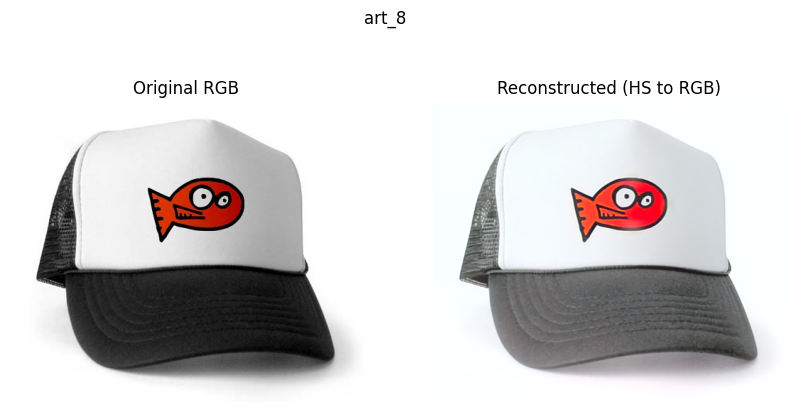

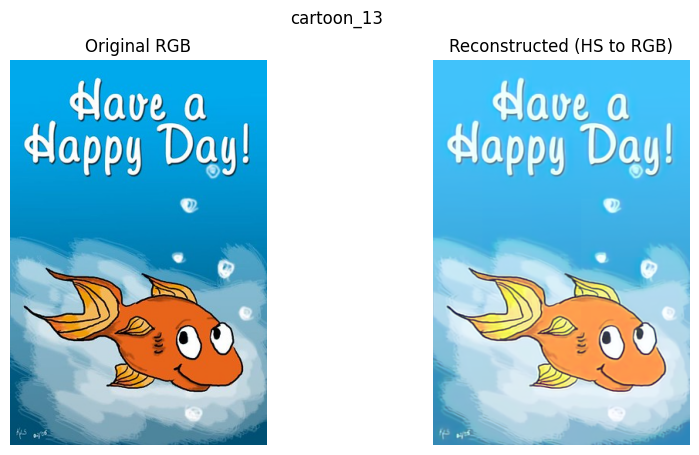

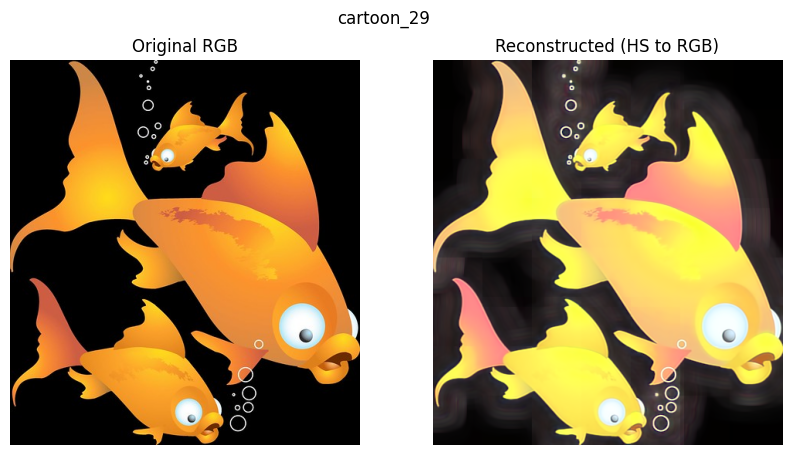

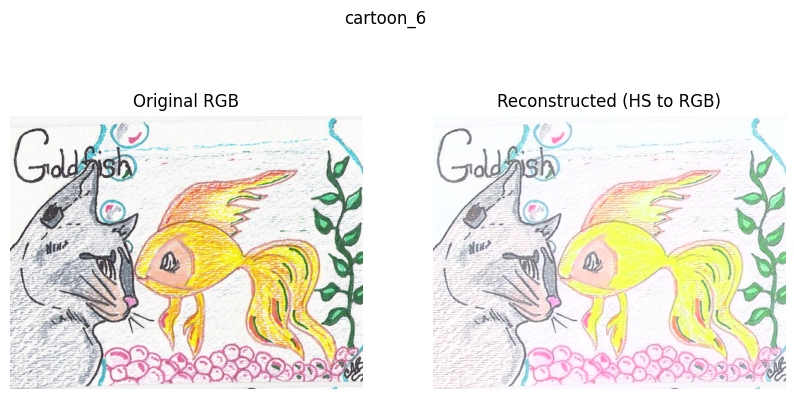

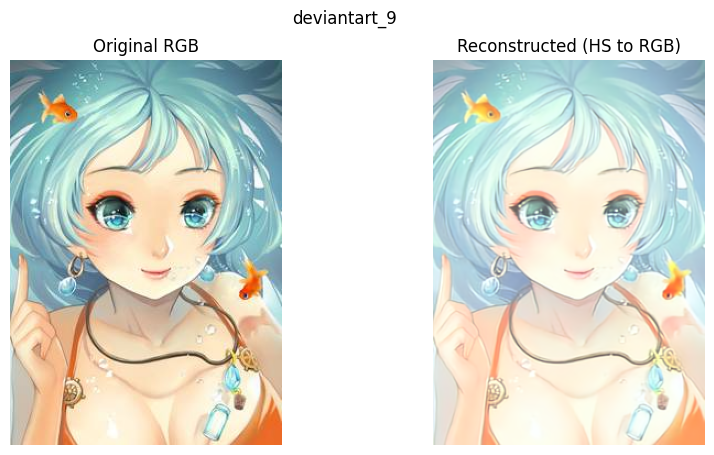

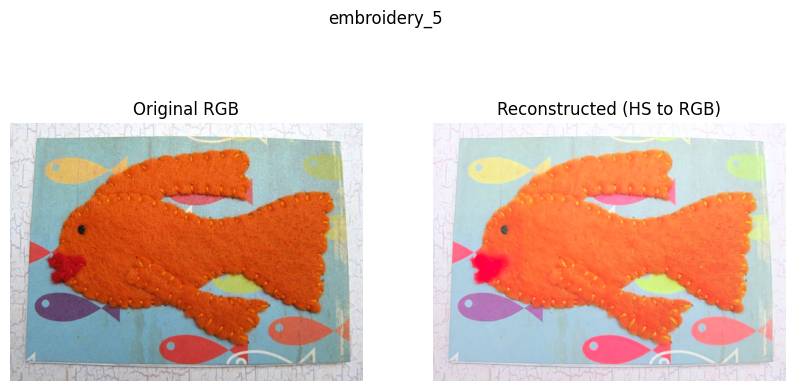

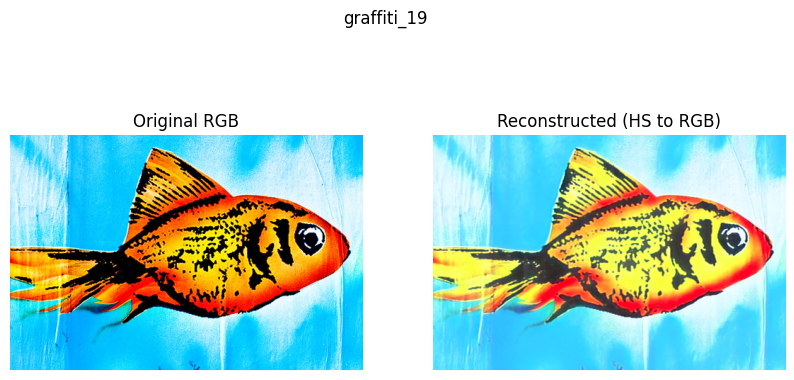

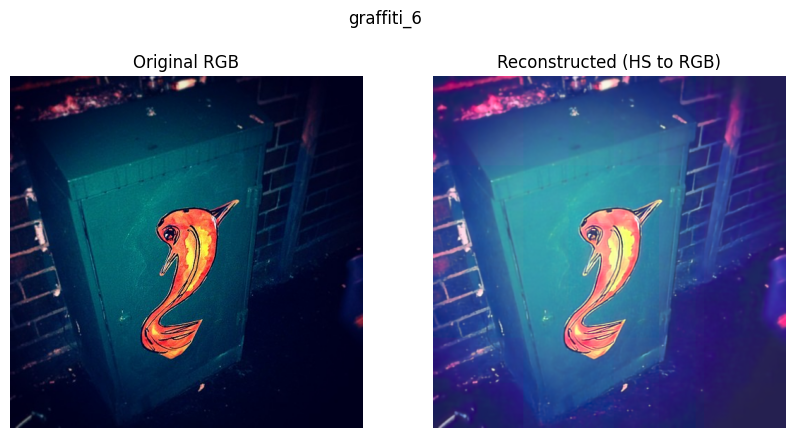

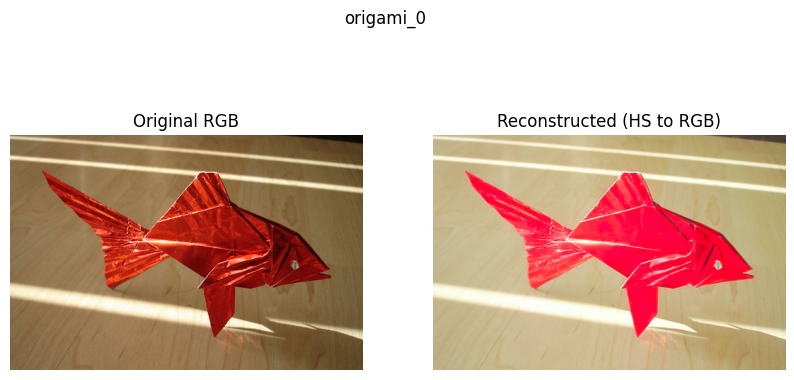

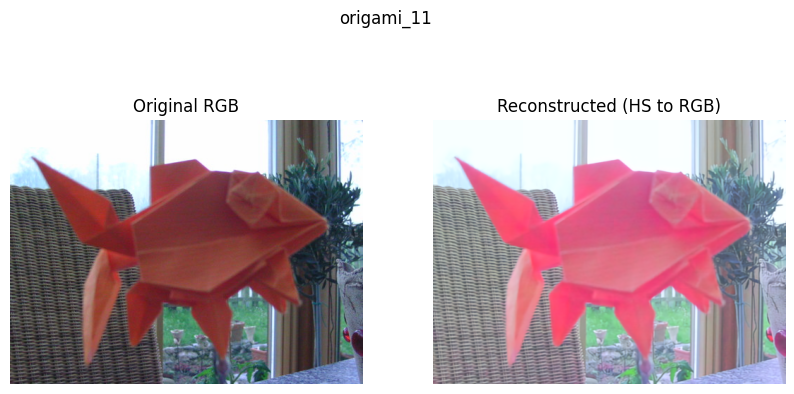

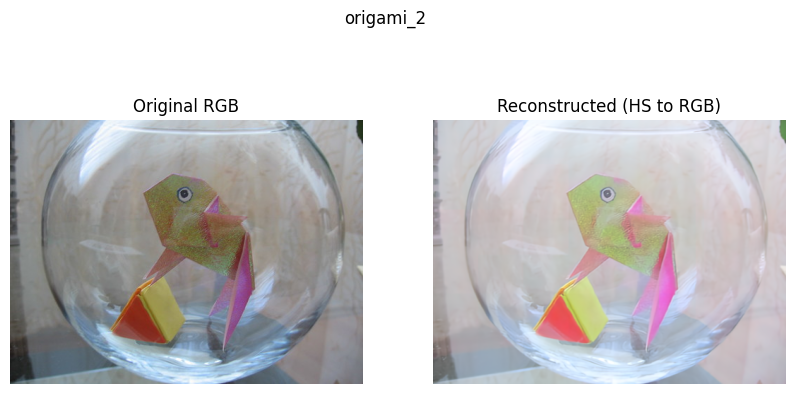

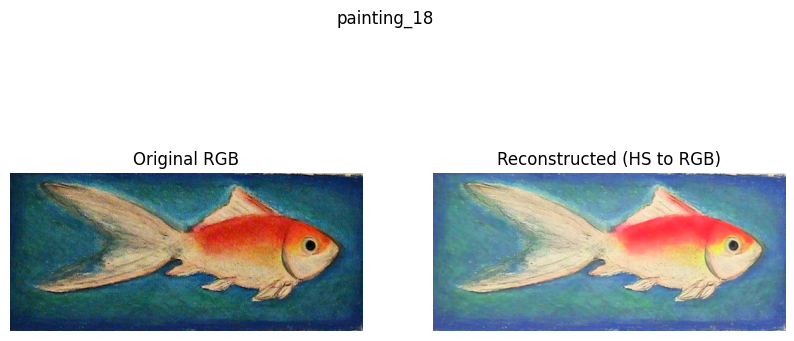

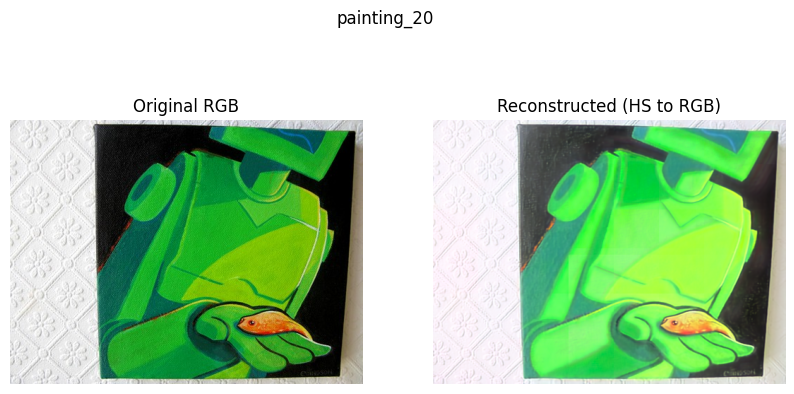

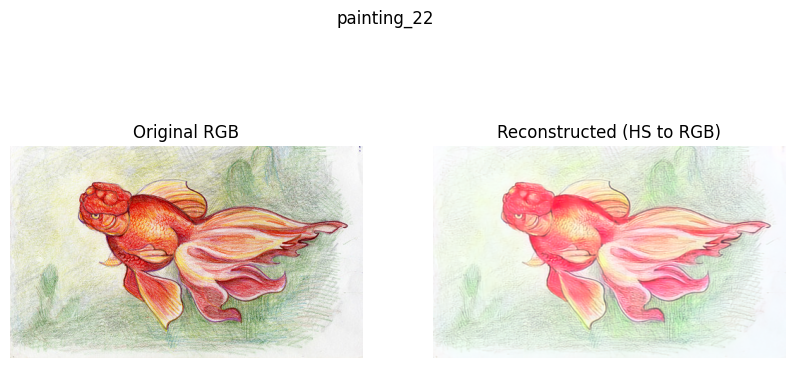

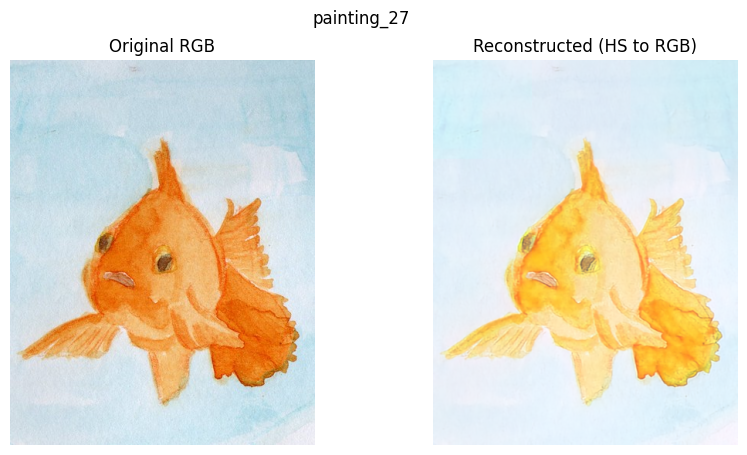

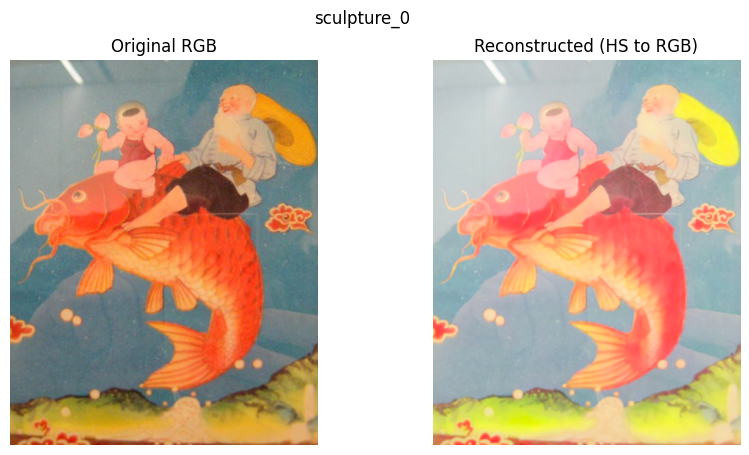

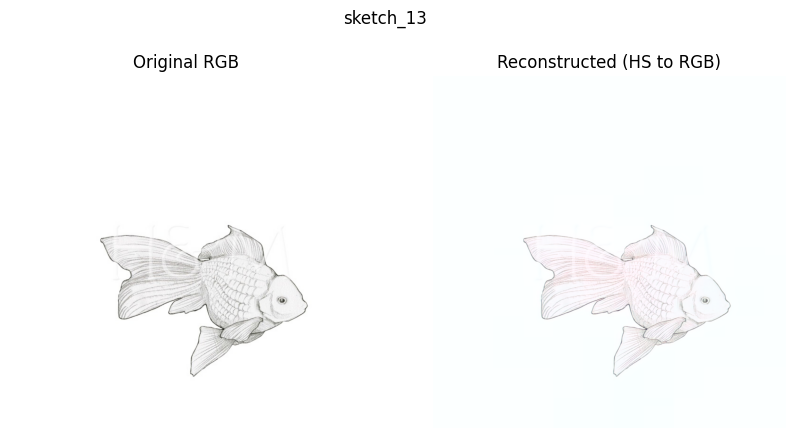

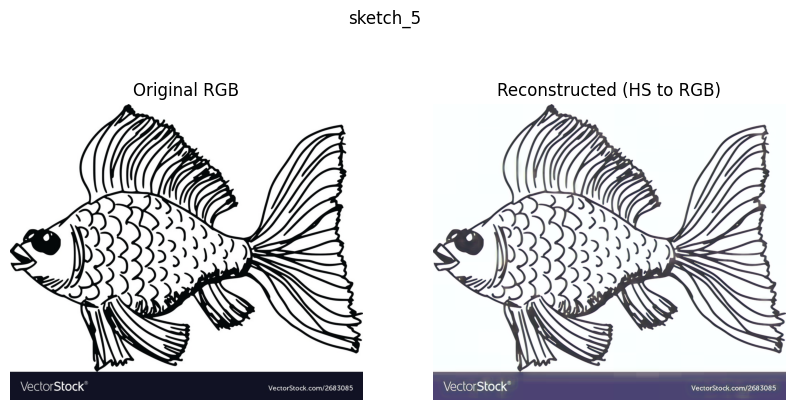

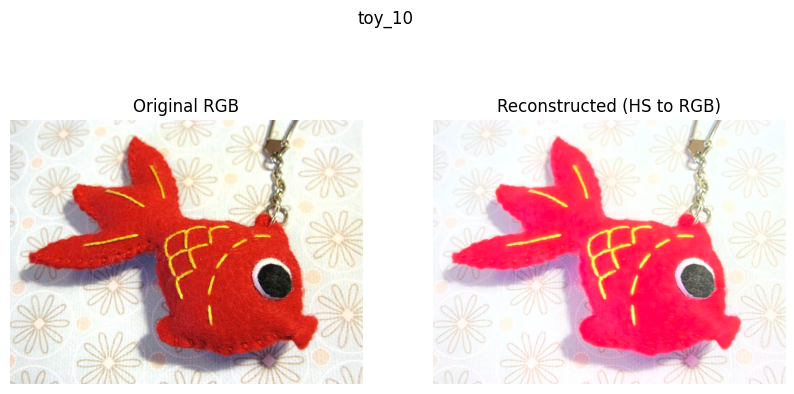

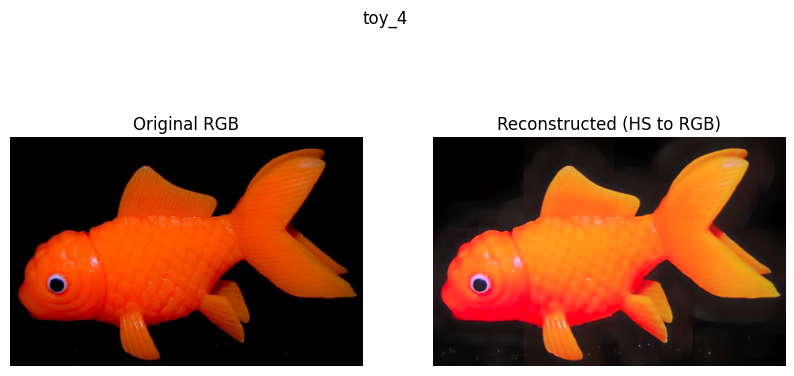

In [ ]:
# Paths
hs_path = '/content/drive/MyDrive/Imagenet_r_results' # .mat files
rgb_path = '/content/drive/MyDrive/Imagenet_r_sample' # .jpg images


HS_RGB_show(hs_path, rgb_path) #shows the images side by side